In [1]:
using Plots
using LinearAlgebra  # for diagonal matrices
using ProgressBars
using ProgressMeter

## 1) Create a thermal state

In [2]:
function thermalstate(ndims, ω, T; plotdiag::Bool=false)
    dimsrange = 1:ndims
    # Create energy eigenstates
    energies = zeros(ndims)
    for i in dimsrange
        energies[i] = exp(-ω*i/T)
    end
    energies ./= sum(energies)
    
    if plotdiag
        plt = plot(dimsrange, energies)
        display(plt)  # use display function to output 
    end

    ρ = Diagonal(energies)
end

thermalstate (generic function with 1 method)

In [3]:
# Define the dimensions of the system's Hilbert space
ndims = 20

# Define the energy of the system and its temperature
ω = 1.
T = 0.5

ρ1 = thermalstate(ndims, ω, T);
ρ2 = thermalstate(ndims, ω, T);

ρ = kron(ρ1, ρ2);

400×400 Diagonal{Float64, Vector{Float64}}:
 0.747645   ⋅         ⋅          ⋅          …   ⋅            ⋅ 
  ⋅        0.101183   ⋅          ⋅              ⋅            ⋅ 
  ⋅         ⋅        0.0136936   ⋅              ⋅            ⋅ 
  ⋅         ⋅         ⋅         0.00185323      ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅          …   ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅          …   ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 
 ⋮                                          ⋱               
  ⋅         ⋅         ⋅          ⋅              ⋅            ⋅ 

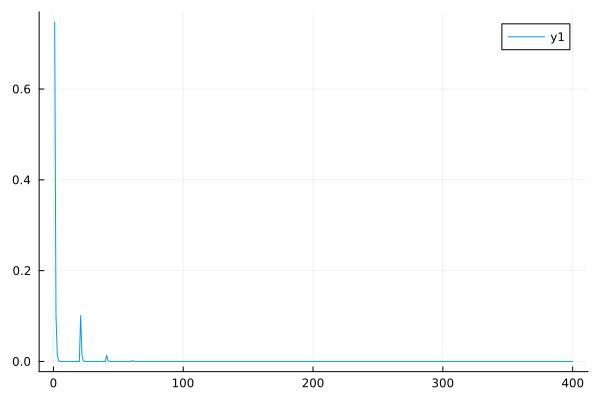

In [4]:
display(ρ)
plot(diag(ρ))

## 2) Create Phaseonium Ancillas   

In [5]:
function phaseonium(α, ϕ)
    [
        α^2 0 0;
        0 (1 - α^2)/2 (1 - α^2)/2 * exp(ϕ*im);
        0 (1 - α^2)/2 * exp(-ϕ*im) (1 - α^2)/2
    ]
end

function dissipationrates(α, ϕ)
    ga = 2*α^2
    gb = (1 + cos(ϕ))*(1 - α^2)
    return real(ga), real(gb)
end

dissipationrates (generic function with 1 method)

In [6]:
# Define excited-state population of phaseonium atoms
α = 1 / 4
ϕ = 1.585589386

# Define the interaction strength
Ω = 1

# Create phaseonium density matrices
η = phaseonium(α, ϕ)

# And get dissipation rates
γα, γβ = dissipationrates(α, ϕ)

(0.125, 0.9236320128073691)

## 3) Create Bosonic Operators

Exp, cosine and sine functions are already well-defined for matrices (they give the same results as QuTiP in Python)

In [7]:
function matrixdistance(M1, M2)
    """Calculates the Frobenius distance between two matrices
    see: https://mathworld.wolfram.com/FrobeniusNorm.html"""
    return sqrt(tr((M1-M2)*(M1-M2)'))
end

function destroy(ndims)
    """Bosonic Annihilation operator"""
    elements = [sqrt(i) for i in 1:(ndims-1)]
    a = diagm(1 => elements)
    return a
end

function create(ndims)
    """Bosonic Creation operator"""
    a = destroy(ndims)
    return a'
end

create (generic function with 1 method)

In [8]:
function C(θ, ndims)
    a = destroy(ndims)
    argument = 2 * a * a'
    return cos(θ * sqrt(argument))
end

function Cp(θ, ndims)
    a = destroy(ndims)
    argument = 2 * a' * a
    return cos(θ * sqrt(argument))
end

function S(θ, ndims)
    a = destroy(ndims)
    argument = 2 * a * a'
    sineop = sin(θ * sqrt(argument))
    dividend = pinv(sqrt(argument))  # pseudoinverse
    return a' * sineop * dividend
end

function Sd(θ, ndims)
    s = S(θ, ndims)
    return s'
end

Sd (generic function with 1 method)

## 4) System Evolution

### 4.1) Define Evolution Parameters

In [9]:
dt = 1.0  # Interaction time
θ = Ω * dt  # Rabi phase

timesteps = 100;

### 4.2) Define Kraus Operators

In [10]:
E0 = sqrt(1 - γα/2 - γβ/2) * kron(I(ndims), I(ndims))
E1 = sqrt(γα/2) * ( kron(C(θ, ndims), C(θ, ndims)) -2 * kron(S(θ, ndims), Sd(θ, ndims)) )
E2 = sqrt(γα) * ( kron(S(θ, ndims), Cp(θ, ndims)) + kron(C(θ, ndims), S(θ, ndims)) )
E3 = sqrt(γβ) * ( kron(Sd(θ, ndims), C(θ, ndims)) + kron(Cp(θ, ndims), Sd(θ, ndims)) )
E4 = sqrt(γβ/2) * ( kron(Cp(θ, ndims), Cp(θ, ndims)) -2 * kron(Sd(θ, ndims), S(θ, ndims)) )
kraus = (E0, E1, E2, E3, E4);

### 4.3) Run Evolution

In [11]:
using Distributed

function D(M, ρ)
    """Dissipator Operator appearing in the Master Equation"""
    sandwich = M * ρ * M'
    commutator = M' * M * ρ + ρ * M' * M
    return sandwich - 1/2 * commutator    
end

function meqevolve(ρ, kraus, timesteps)
    Δρ = zeros(size(ρ))
    for t in 1:timesteps
        for Ek in kraus[2:length(kraus)]
            Δρ += D(Ek, ρ)
        end
        ρ += Δρ
    end
    return ρ
end

function krausevolve(ρ, kraus, timesteps)
    """Evolve the system with distributed operations"""
    ρt = ρ
    for t in 1:timesteps
        for Ek in kraus
              ρt = Ek * ρ * Ek'
        end
        ρ = ρt
    end
    ρ
end

@everywhere function mulitmeqevolve(ρ, kraus, timesteps)
    Δρ = zeros(size(ρ))
    for t in 1:timesteps
        for Ek in kraus[2:length(kraus)]
            Δρ += D(Ek, ρ)
        end
        ρ += Δρ
    end
    return ρ
end

@everywhere function multikrausevolve(ρ, kraus, timesteps)
    """Evolve the system with distributed operations"""
    ρt = ρ
    for t in 1:timesteps
        ρt = @distributed (+) for Ek in kraus
              Ek * ρ * Ek'
        end
        ρ = ρt
    end
    ρ
end

*Do some benchmark*

In [12]:
using BenchmarkTools

ρt = ρ;

In [13]:
b1 = @benchmarkable meqevolve(ρt, kraus, 1000) seconds=40;

tune!(b1)

run(b1)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  26.927 s …   27.186 s  ┊ GC (min … max): 9.83% … 9.84%
 Time  (median):     27.057 s               ┊ GC (median):    9.84%
 Time  (mean ± σ):   27.057 s ± 183.199 ms  ┊ GC (mean ± σ):  9.84% ± 0.01%

  █                                                         █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  26.9 s          Histogram: frequency by time         27.2 s <

 Memory estimate: 48.88 GiB, allocs estimate: 82003.

In [14]:
b1 = @benchmarkable krausevolve(ρt, kraus, 1000) seconds=40;

tune!(b1)

run(b1)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  15.928 s …  16.005 s  ┊ GC (min … max): 3.48% … 3.50%
 Time  (median):     15.987 s              ┊ GC (median):    3.51%
 Time  (mean ± σ):   15.974 s ± 40.260 ms  ┊ GC (mean ± σ):  3.50% ± 0.01%

  █                                           █            █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  15.9 s         Histogram: frequency by time           16 s <

 Memory estimate: 10.73 GiB, allocs estimate: 29999.

In [21]:
addprocs(4)

b2 = @benchmarkable mulitmeqevolve(ρt, kraus, 1000) seconds=40;

tune!(b2)

run(b2)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  27.154 s … 28.698 s  ┊ GC (min … max): 10.14% … 10.27%
 Time  (median):     27.926 s             ┊ GC (median):    10.21%
 Time  (mean ± σ):   27.926 s ±  1.092 s  ┊ GC (mean ± σ):  10.21% ±  0.09%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  27.2 s         Histogram: frequency by time        28.7 s <

 Memory estimate: 48.88 GiB, allocs estimate: 82002.

In [22]:
rmprocs(workers())

Task (done) @0x00000251a3371370

In [16]:
addprocs(4)

b2 = @benchmarkable multikrausevolve(ρt, kraus, 1000) seconds=40;

tune!(b2)

run(b2)

LoadError: InterruptException:

In [23]:
rmprocs(workers())

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed D:\Program Files\Julia-1.9.4\share\julia\stdlib\v1.9\Distributed\src\cluster.jl:1049


Task (done) @0x00000251a46d7650

In [17]:
addprocs(4)

ρt = multikrausevolve(ρt, kraus, 5000);

## 5) Results

In [18]:
function is_diagonal(mat::Matrix)
    return mat == Diagonal(diag(mat))
end

function is_density(mat::Matrix; threshold = 1e-5)
    return tr(mat) - 1 < threshold
end

is_diagonal(ρt), is_density(ρt)

(false, true)

In [19]:
function partial_trace(mat::Matrix, dim::Int, system::Int)
    d = size(mat)[1] ÷ dim
    mat = reshape(mat, (d, dim, d, dim))
    if system == 1
        mat = permutedims(mat, (2, 1, 4, 3))
    end
    mat = reshape(mat, (dim, d^2, dim))
    mat = dropdims(sum(mat, dims=2), dims=2)
    return mat
end

partial_trace(ρt, ndims, 1)

20×20 Matrix{Float64}:
 0.747645     0.101183     0.0136936    …   1.73418e-16   2.34696e-17
 0.101183     0.0136936    0.00185323       2.34696e-17   3.17626e-18
 0.0136936    0.00185323   0.000250807      3.17626e-18   4.2986e-19
 0.00185323   0.000250807  3.3943e-5        4.2986e-19    5.81753e-20
 0.000250807  3.3943e-5    4.59369e-6       5.81753e-20   7.87316e-21
 3.3943e-5    4.59369e-6   6.21688e-7   …   7.87316e-21   1.06552e-21
 4.59369e-6   6.21688e-7   8.41364e-8       1.06552e-21   1.44202e-22
 6.21688e-7   8.41364e-8   1.13866e-8       1.44202e-22   1.95156e-23
 8.41364e-8   1.13866e-8   1.54101e-9       1.95157e-23   2.64115e-24
 1.13866e-8   1.54101e-9   2.08553e-10      2.64106e-24   3.57444e-25
 1.54101e-9   2.08553e-10  2.82246e-11  …   3.57507e-25   4.8373e-26
 2.08553e-10  2.82246e-11  3.81979e-12      4.83593e-26   6.5477e-27
 2.82246e-11  3.81979e-12  5.16952e-13      6.51594e-27   8.8687e-28
 3.81979e-12  5.16952e-13  6.99618e-14      8.66576e-28   1.20182e-28
 

In [20]:
ρ00 = diag(ρt)[1]
ρ11 = diag(ρt)[2]
T = - 1 / log(ρ11 / ρ00)

0.49999999988062427